# XGBoost 模型训练

使用标准化后的数据训练 XGBoost 回归模型，预测 lipid(%) 含量。

## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## 2. 加载数据

In [2]:
# 数据路径
TRAIN_PATH = 'data/augmentdata/train_normalized.csv'
TEST_PATH = 'data/augmentdata/test_normalized.csv'

# 特征列和目标列
FEATURE_COLS = ['pH', 'DO', 'COD', 'BOD', 'Total photosynthetic pigments', 
                'Dry cell weight', 'protein(%)', 'H(%)', 'O(%)']
TARGET_COL = 'lipid(%)'

# 加载数据
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# 准备特征和目标
X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]
X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]

print(f'训练集: {X_train.shape[0]} 样本, {X_train.shape[1]} 特征')
print(f'测试集: {X_test.shape[0]} 样本, {X_test.shape[1]} 特征')

训练集: 140 样本, 9 特征
测试集: 8 样本, 9 特征


## 3. 网格搜索超参数调优

基于测试集 R² 寻找最佳参数组合。

In [3]:
# 使用 GridSearchCV 进行 5 折交叉验证超参数调优
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 基础模型
base_model = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)

# GridSearchCV: 在训练集内部进行 5 折交叉验证
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# 在训练集上进行交叉验证调参
grid_search.fit(X_train, y_train)

# 最佳模型和参数
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_r2 = grid_search.best_score_

print(f'\n5 折交叉验证最佳 R²: {best_cv_r2:.4f}')
print('\n最佳参数:')
for param, value in best_params.items():
    print(f'  {param}: {value}')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

5 折交叉验证最佳 R²: 0.9076

最佳参数:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 6
  min_child_weight: 3
  n_estimators: 150
  subsample: 0.8


## 4. 模型评估

In [4]:
# 使用交叉验证预测结果评估训练集性能
y_train_cv_pred = cross_val_predict(best_model, X_train, y_train, cv=5)
y_test_pred = best_model.predict(X_test)

# 计算评估指标
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_cv_pred))
train_mae = mean_absolute_error(y_train, y_train_cv_pred)
train_r2 = r2_score(y_train, y_train_cv_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('模型评估结果\n')
print('训练集 (5 折交叉验证):')
print(f'  RMSE: {train_rmse:.4f}')
print(f'  MAE:  {train_mae:.4f}')
print(f'  R²:   {train_r2:.4f}')
print()
print('测试集:')
print(f'  RMSE: {test_rmse:.4f}')
print(f'  MAE:  {test_mae:.4f}')
print(f'  R²:   {test_r2:.4f}')

模型评估结果

训练集 (5 折交叉验证):
  RMSE: 1.5553
  MAE:  0.8689
  R²:   0.9051

测试集:
  RMSE: 3.7729
  MAE:  2.9067
  R²:   0.2611


## 5. 特征重要性分析

特征重要性排名:

                      feature  importance
                         O(%)    0.456477
                         H(%)    0.158746
              Dry cell weight    0.151674
                           DO    0.080754
Total photosynthetic pigments    0.037871
                           pH    0.036605
                          BOD    0.030175
                   protein(%)    0.027662
                          COD    0.020036


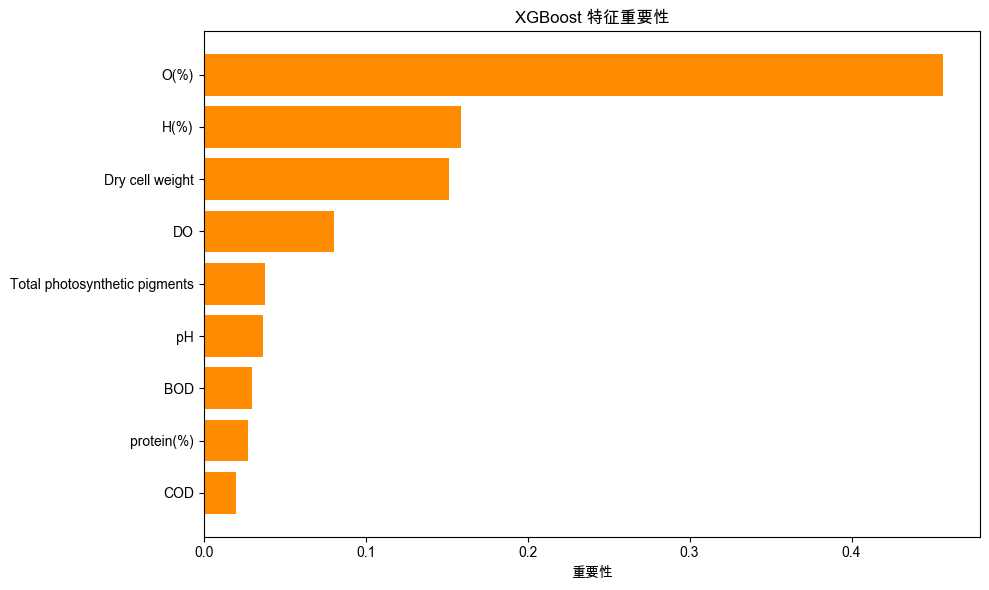

In [5]:
# 获取特征重要性
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print('特征重要性排名:\n')
print(feature_importance.to_string(index=False))

# 可视化特征重要性
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance['feature'], feature_importance['importance'], color='darkorange')
ax.set_xlabel('重要性')
ax.set_title('XGBoost 特征重要性')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 6. 预测结果可视化

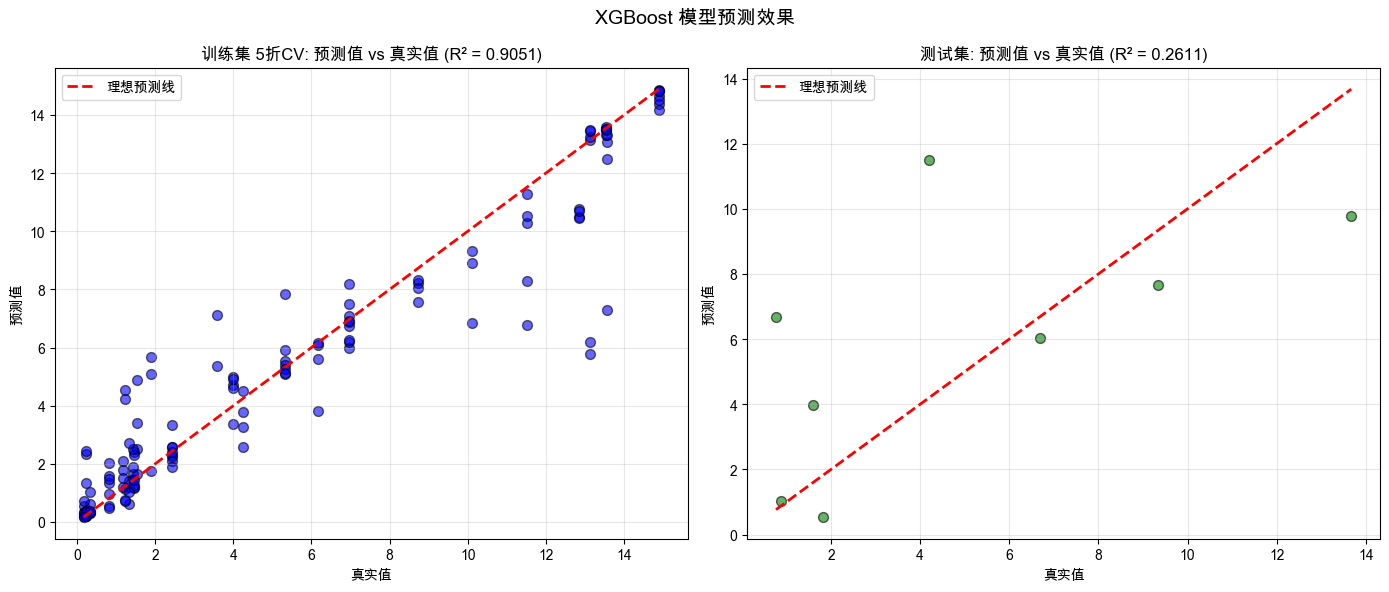

In [6]:
# 预测值 vs 真实值散点图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 训练集
ax1 = axes[0]
ax1.scatter(y_train, y_train_cv_pred, alpha=0.6, color='blue', edgecolors='k', s=50)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='理想预测线')
ax1.set_xlabel('真实值')
ax1.set_ylabel('预测值')
ax1.set_title(f'训练集 5折CV: 预测值 vs 真实值 (R² = {train_r2:.4f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 测试集
ax2 = axes[1]
ax2.scatter(y_test, y_test_pred, alpha=0.6, color='green', edgecolors='k', s=50)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='理想预测线')
ax2.set_xlabel('真实值')
ax2.set_ylabel('预测值')
ax2.set_title(f'测试集: 预测值 vs 真实值 (R² = {test_r2:.4f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('XGBoost 模型预测效果', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. 测试集预测详情

In [7]:
# 显示测试集的预测详情
test_results = pd.DataFrame({
    '真实值': y_test.values,
    '预测值': y_test_pred,
    '误差': y_test.values - y_test_pred,
    '绝对误差': np.abs(y_test.values - y_test_pred)
})

print('测试集预测详情:\n')
test_results

测试集预测详情:



,真实值,预测值,误差,绝对误差
0,6.690000,6.041053,0.648947,0.648947
1,9.347000,7.656846,1.690154,1.690154
2,0.766912,6.687177,-5.920265,5.920265
3,0.881452,1.021768,-0.140316,0.140316
4,1.587000,3.984276,-2.397276,2.397276
5,4.208457,11.492400,-7.283944,7.283944
6,1.822245,0.529747,1.292498,1.292498
7,13.674000,9.793893,3.880107,3.880107
